In [1]:
import os
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from tqdm import tqdm

In [2]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())


2.6.0+cu126
True


In [3]:

# ================================================================
# CONFIG
# ================================================================

REDDIT_CSV = "reddit_df.csv"
BITCOIN_CSV = "Bitcoin.csv"

MODEL_NAME = "cardiffnlp/twitter-roberta-base-sentiment-latest"
OUTPUT_DETAILED = "sentiment_detailed.csv"
OUTPUT_DAILY = "sentiment_daily.csv"
AGG_FREQ = "D"   # D = diario, H = horario si lo necesitas


# ================================================================
# LOAD DATASETS
# ================================================================

def load_reddit_dataset(path: str) -> pd.DataFrame:
    df = pd.read_csv(path)
    df["datetime"] = pd.to_datetime(df["datetime"], errors="coerce", utc=True)
    df = df.dropna(subset=["datetime", "comment"])

    df = df.rename(columns={
        "datetime": "timestamp",
        "comment": "text"
    })

    df["source"] = "reddit_comments"
    return df[["timestamp", "text", "source"]]


def load_bitcoin_dataset(path: str) -> pd.DataFrame:
    df = pd.read_csv(path)

    df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce", utc=True)
    df = df.dropna(subset=["timestamp"])

    df["title"] = df["title"].fillna("")
    df["body"] = df["body"].fillna("")
    df["text"] = (df["title"] + " " + df["body"]).str.strip()

    df = df[df["text"] != ""]

    df["source"] = "reddit_bitcoin_posts"
    return df[["timestamp", "text", "source"]]


# ================================================================
# SENTIMENT MODEL
# ================================================================

def load_sentiment_model(model_name: str):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name)
    nlp = pipeline(
        "sentiment-analysis",
        model=model,
        tokenizer=tokenizer,
        truncation=True,
        max_length=256
    )
    return nlp, model.config.id2label


def label_to_score(label: str) -> float:
    """Convierte etiquetas (POS/NEU/NEG) en score numérico."""
    label = label.upper()
    if "NEG" in label:
        return -1.0
    if "NEU" in label:
        return 0.0
    if "POS" in label:
        return 1.0
    return 0.0


# ================================================================
# SENTIMENT PIPELINE
# ================================================================

def compute_sentiment(df: pd.DataFrame, nlp) -> pd.DataFrame:
    tqdm.pandas(desc="Sentiment analysis")

    def analyze(text):
        result = nlp(str(text)[:512])[0]
        return result

    results = df["text"].progress_apply(analyze)

    df["sent_label"] = results.apply(lambda x: x["label"])
    df["sent_score_raw"] = results.apply(lambda x: x["score"])
    df["sent_score"] = df["sent_label"].map(label_to_score)
    df["sent_score_weighted"] = df["sent_score"] * df["sent_score_raw"]

    return df


def aggregate_daily(df: pd.DataFrame, freq="D") -> pd.DataFrame:
    df = df.set_index("timestamp")
    agg = df.resample(freq).agg({
        "sent_score": "mean",
        "sent_score_weighted": "mean",
        "text": "count"
    })

    agg = agg.rename(columns={
        "sent_score": "sentiment_mean",
        "sent_score_weighted": "sentiment_weighted_mean",
        "text": "num_texts"
    })

    agg = agg.dropna(how="all")
    agg = agg.reset_index()
    return agg


# ================================================================
# MAIN
# ================================================================

def main():
    print("[INFO] Loading datasets...")

    reddit = load_reddit_dataset(REDDIT_CSV)
    btc = load_bitcoin_dataset(BITCOIN_CSV)

    df = pd.concat([reddit, btc], ignore_index=True)
    df = df.sort_values("timestamp")

    print(f"[INFO] Total rows: {len(df)}")

    print("[INFO] Loading sentiment model...")
    nlp, labels = load_sentiment_model(MODEL_NAME)
    print(f"[INFO] Model labels: {labels}")

    print("[INFO] Running sentiment analysis...")
    df_sent = compute_sentiment(df, nlp)

    print(f"[INFO] Saving detailed dataset to {OUTPUT_DETAILED}")
    df_sent.to_csv(OUTPUT_DETAILED, index=False)

    print("[INFO] Aggregating daily sentiment...")
    df_daily = aggregate_daily(df_sent, AGG_FREQ)

    print(f"[INFO] Saving daily sentiment to {OUTPUT_DAILY}")
    df_daily.to_csv(OUTPUT_DAILY, index=False)

    print("[INFO] Done.")




In [4]:
if __name__ == "__main__":
    main()

[INFO] Loading datasets...
[INFO] Total rows: 3790
[INFO] Loading sentiment model...


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

C:\Users\Nitro\AppData\Roaming\Python\Python312\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Nitro\.cache\huggingface\hub\models--cardiffnlp--twitter-roberta-base-sentiment-latest. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sent

[INFO] Model labels: {0: 'negative', 1: 'neutral', 2: 'positive'}
[INFO] Running sentiment analysis...


Sentiment analysis:   0%|          | 0/3790 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

Sentiment analysis: 100%|██████████| 3790/3790 [01:37<00:00, 38.98it/s]


[INFO] Saving detailed dataset to sentiment_detailed.csv
[INFO] Aggregating daily sentiment...
[INFO] Saving daily sentiment to sentiment_daily.csv
[INFO] Done.


In [5]:
import pandas as pd

df = pd.read_csv("sentiment_detailed.csv", parse_dates=["timestamp"])

print(df.head())
print(df.sent_label.value_counts())


                  timestamp  \
0 2022-12-08 13:59:26+00:00   
1 2022-12-08 13:59:26+00:00   
2 2022-12-08 14:15:19+00:00   
3 2022-12-08 14:15:19+00:00   
4 2022-12-08 14:33:26+00:00   

                                                text                source  \
0  messing up at robosats hi everyone i tried out...       reddit_comments   
1  Messing up at Robosats Hi Everyone,\n\nI tried...  reddit_bitcoin_posts   
2  coinbase transaction if anyone can please clar...       reddit_comments   
3  Coinbase transaction If anyone can please clar...  reddit_bitcoin_posts   
4  desire to sell I just realized this dip in Bit...  reddit_bitcoin_posts   

  sent_label  sent_score_raw  sent_score  sent_score_weighted  
0   positive        0.451700         1.0             0.451700  
1    neutral        0.455295         0.0             0.000000  
2    neutral        0.872928         0.0             0.000000  
3    neutral        0.866659         0.0             0.000000  
4   positive        0.56

In [6]:
conteo = df["sent_label"].value_counts()
print("Conteo de sentimientos:")
print(conteo)


Conteo de sentimientos:
sent_label
neutral     2193
negative    1077
positive     520
Name: count, dtype: int64


In [7]:
agrupado = df.groupby("sent_label")[["sent_score", "sent_score_raw", "sent_score_weighted"]].mean()
print("Promedios por sentimiento:")
print(agrupado)


Promedios por sentimiento:
            sent_score  sent_score_raw  sent_score_weighted
sent_label                                                 
negative          -1.0        0.708480            -0.708480
neutral            0.0        0.717937             0.000000
positive           1.0        0.753963             0.753963


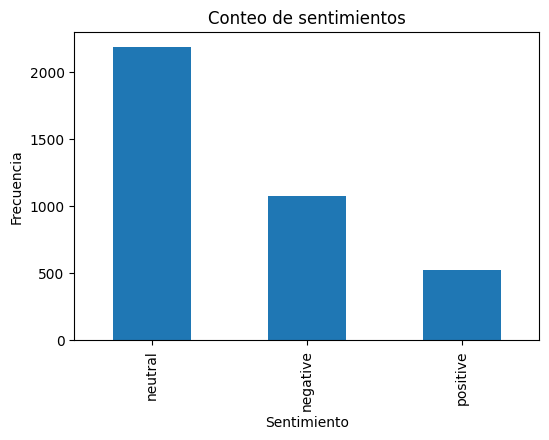

In [8]:
import matplotlib.pyplot as plt

df["sent_label"].value_counts().plot(kind="bar", figsize=(6,4))
plt.title("Conteo de sentimientos")
plt.xlabel("Sentimiento")
plt.ylabel("Frecuencia")
plt.show()


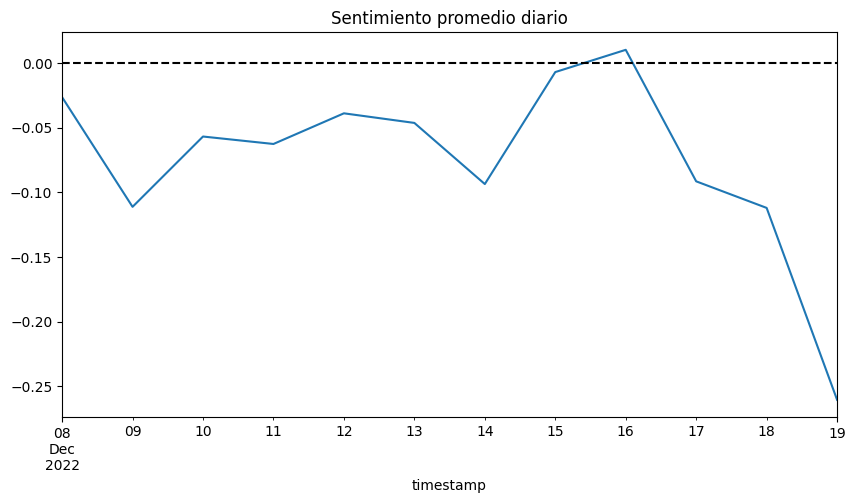

In [9]:
df_daily = pd.read_csv("sentiment_daily.csv", parse_dates=["timestamp"])
df_daily.set_index("timestamp", inplace=True)

df_daily["sentiment_mean"].plot(figsize=(10,5))
plt.title("Sentimiento promedio diario")
plt.axhline(0, color="black", linestyle="--")
plt.show()


In [10]:
# Agregar número de textos por día y sentimientos
df['date'] = df['timestamp'].dt.date

evolucion = df.groupby(['date', 'sent_label']).size().unstack(fill_value=0)

print(evolucion.head())


sent_label  negative  neutral  positive
date                                   
2022-12-08        16       46        14
2022-12-09        32       96        16
2022-12-10        21      107        13
2022-12-11        46      112        34
2022-12-12        56      129        47


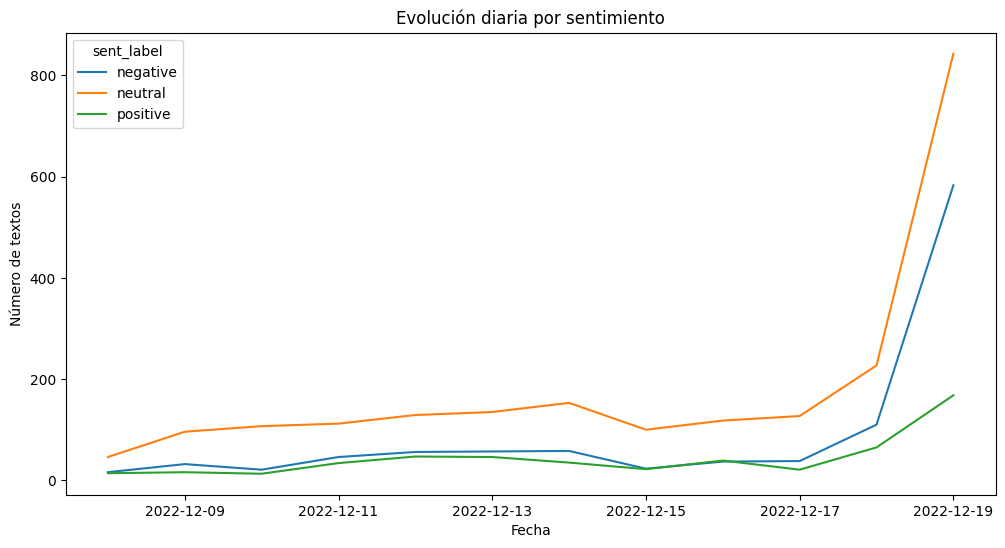

In [11]:
evolucion.plot(kind='line', figsize=(12,6))
plt.title("Evolución diaria por sentimiento")
plt.xlabel("Fecha")
plt.ylabel("Número de textos")
plt.show()


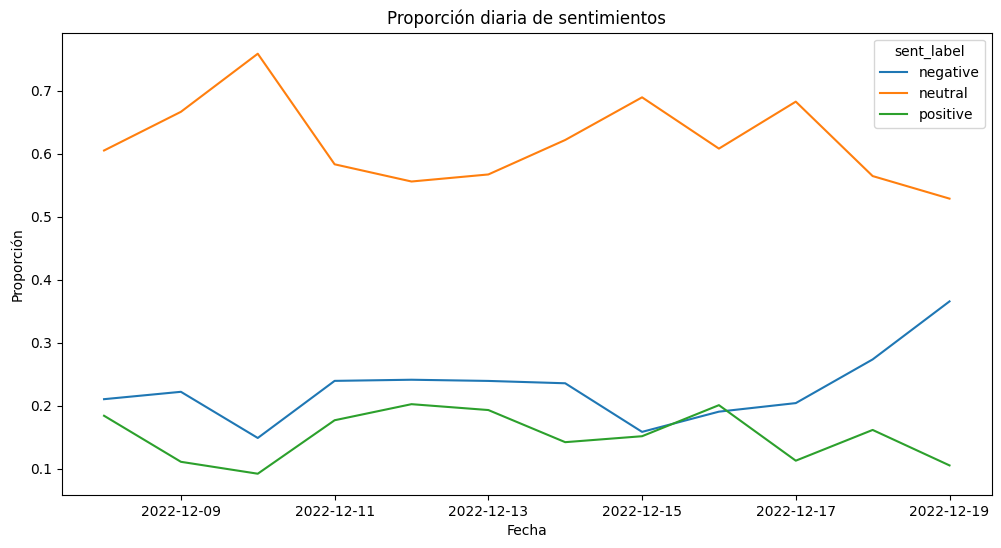

In [12]:
proporciones = evolucion.div(evolucion.sum(axis=1), axis=0)

proporciones.plot(kind="line", figsize=(12,6))
plt.title("Proporción diaria de sentimientos")
plt.xlabel("Fecha")
plt.ylabel("Proporción")
plt.show()
